In [1]:
import pickle, json
import seaborn as sns
import matplotlib.pyplot as plt
import re, os
from collections import defaultdict
from tqdm import tqdm

In [2]:
output_dir = "/home/myang4/mrt-analysis/outputs/regret"
folders = ["base", "mrt", "grpo"]
max_steps = 99 # maximum number of steps to break into
group_size = 10

### Load data

In [3]:
for folder in folders:
    data = {}
    for i in range(0, 15, 5):
        with open(os.path.join(output_dir, folder, f'pass_at_k/pass_at_k_{i}_{i+5}.pkl'), 'rb') as f:
            data |= pickle.load(f)
    
    with open(os.path.join(output_dir, folder, f'pass_at_k/pass_at_k.pkl'), "wb") as f:
        pickle.dump(data, f)

### Break into meta steps

In [4]:
def break_into_meta_steps(data):
    k_meta_steps = defaultdict(list)

    for n in tqdm(range(len(data))):
        for text in data[n]:
            meta_steps = []
            
            steps = text.split('\n\n')
            prev_i = 0
            num_s_steps = max_steps
            for i, step in enumerate(steps):
                if num_s_steps == 0:
                    break

                if step.startswith("Wait") or step.startswith("But wait") or step.startswith("Alternatively") or step.startswith("Is there another way to think about this?") or step.startswith("But let me double-check") or step.startswith("But hold on"):
                    
                    if prev_i == i or prev_i == i-1 or prev_i == i-2:
                        continue
                    
                    elif prev_i < i:
                        meta_step = "\n\n".join(steps[prev_i:i]).rstrip('\n')
                        meta_steps.append(meta_step)
                        num_s_steps -= 1
                    
                    prev_i = i

            if prev_i < len(steps):
                meta_step = "\n\n".join(steps[prev_i:]).rstrip('\n')
                meta_steps.append(meta_step)
            
            k_meta_steps[n].append(meta_steps)
    
    return k_meta_steps

In [5]:
folder_to_k_meta_steps = {}

for folder in folders:
    with open(os.path.join(output_dir, folder, f'pass_at_k/pass_at_k.pkl'), "rb") as f:
        data = pickle.load(f)
    folder_to_k_meta_steps[folder] = break_into_meta_steps(data)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 141.56it/s]


### Plot step length distributions

In [13]:
def plot_step_lengths(k_meta_steps):
    steps_dist = []

    for n, k_tries in k_meta_steps.items():
        for entry in k_tries:
            steps_dist.append(len(entry))

    sns.histplot(steps_dist, stat='count')
    plt.show()

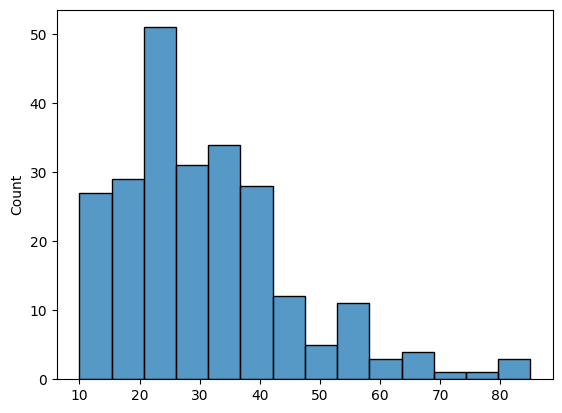

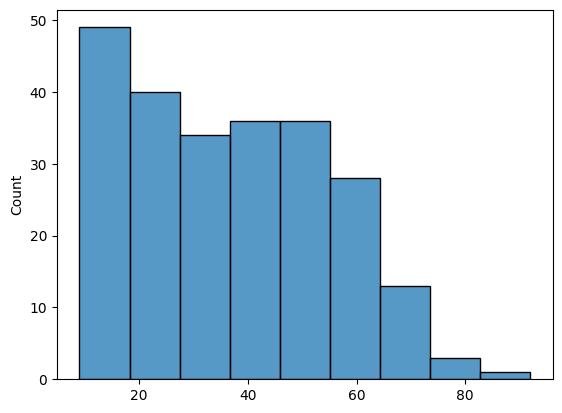

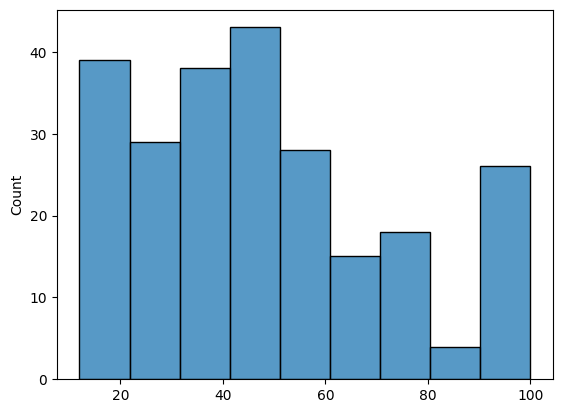

In [14]:
for folder in folders:
    plot_step_lengths(folder_to_k_meta_steps[folder])

### Merge into larger meta steps

In [15]:
def merge_meta_steps(k_meta_steps):
    meta_steps = defaultdict(list)

    for n in k_meta_steps:
        for k in range(len(k_meta_steps[n])):
            new_k_meta_steps = []
            for i in range(0, len(k_meta_steps[n][k]), group_size):
                concatenated_meta_step = "\n\n".join(k_meta_steps[n][k][i:i+group_size])
                new_k_meta_steps.append(concatenated_meta_step)
            meta_steps[n].append(new_k_meta_steps)
    
    return meta_steps

In [16]:
folder_to_meta_steps = {}
for folder in folders:
    folder_to_meta_steps[folder] = merge_meta_steps(folder_to_k_meta_steps[folder])

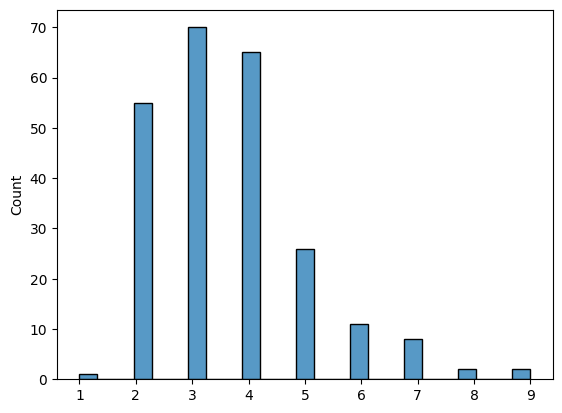

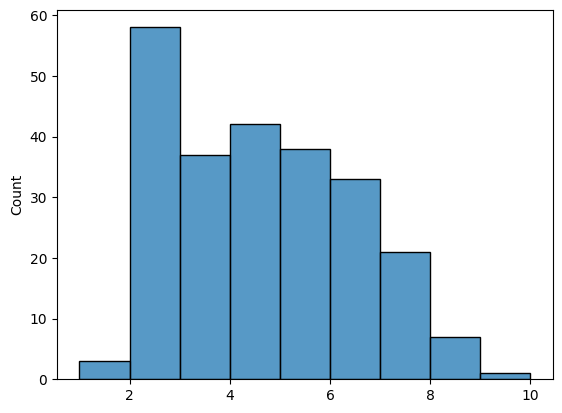

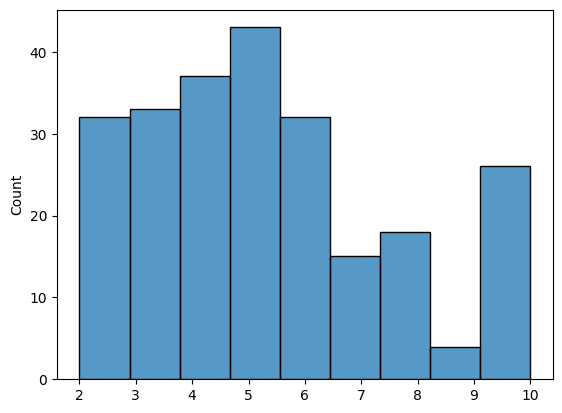

In [17]:
for folder in folders:
    plot_step_lengths(folder_to_meta_steps[folder])

### Save data

In [18]:
for folder in folders:
    with open(os.path.join(output_dir, folder, f'pass_at_k/prefixes.pkl'), "wb") as f:
        pickle.dump(folder_to_meta_steps[folder], f)